In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import os
from pathlib import Path
import copy
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, PyMol
from rdkit.Chem import Draw
import MDAnalysis as mda
import prolif as plf
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# load traj
u = mda.Universe(plf.datafiles.TOP, plf.datafiles.TRAJ)
prot = u.select_atoms("protein")
lig = u.select_atoms("resname LIG")
pmol = plf.Molecule.from_mda(prot)
lmol = plf.Molecule.from_mda(lig)

In [27]:
lig, prot

(<AtomGroup with 79 atoms>, <AtomGroup with 4988 atoms>)

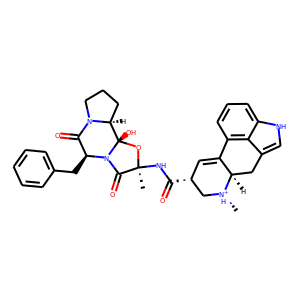

In [4]:
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol)

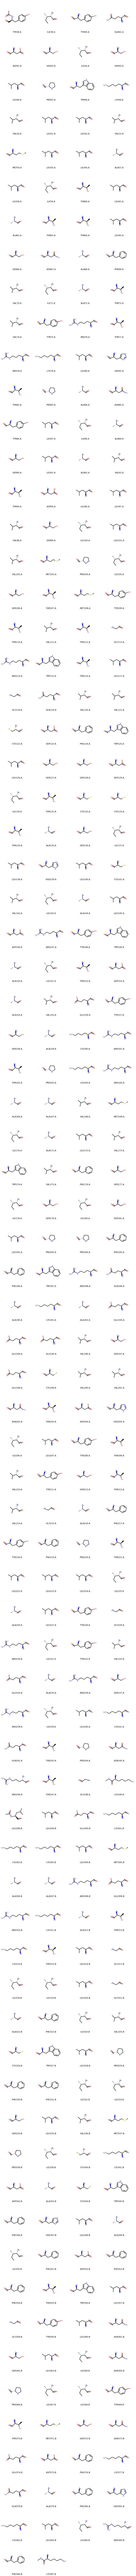

In [28]:
# display all residues
frags = []
for res in pmol:
    mol = Chem.RemoveHs(res)
    mol.RemoveAllConformers()
    frags.append(mol)
Draw.MolsToGridImage(frags, legends=[str(res.resid) for res in pmol], subImgSize=(200, 200),
                     molsPerRow=4, maxMols=prot.n_residues)

In [6]:
rg = pmol.residues
rg

<prolif.residue.ResidueGroup with 302 residues at 0x7f6e2d6b2820>

In [7]:
rg.select((100 <= rg.number) & (rg.number < 200))

<prolif.residue.ResidueGroup with 100 residues at 0x7f6e2d23aa00>

In [8]:
rg.select((rg.chain == "A") ^ (rg.name == "ALA"))

<prolif.residue.ResidueGroup with 199 residues at 0x7f6e2d23a4f0>

In [9]:
rg.select((rg.name == "ARG") & ((rg.number == 76)))[0].resid is rg["ARG76.A"].resid

True

In [10]:
fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)

<prolif.fingerprint.Fingerprint: 8 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'Cationic', 'Anionic', 'PiCation', 'CationPi', 'PiStacking'] at 0x7f6e2d23afd0>

In [11]:
df = fp.to_dataframe()
df

Frame     TYR38.A    TYR109.A    THR110.A    TRP125.A    LEU126.A  \
         Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
0      0           0           1           0           1           0   
1     10           0           1           0           1           1   
2     20           0           1           1           1           1   
3     30           0           1           1           1           1   
4     40           0           1           0           1           1   
5     50           1           1           0           0           0   
6     60           0           0           0           0           0   
7     70           0           1           0           1           1   
8     80           0           1           0           0           1   
9     90           0           0           0           1           0   
10   100           0           0           0           1           1   
11   110           1           0           0           1           0   
12   120           1           0           0           0           0   
13   130           0           0           0           1           0   
14   140           0           0           0           0           0   
15   150           0           0           0           0           0   
16   160           0           0           0           0           1   
17   170           0           0           0           1           0   
18   180           0           0           0           1           1   
19   190           0           1           0           1           1   
20   200           1           1           0           0           0   
21   210           1           1           0           1           0   
22   220           1           0           0           0           0   
23   230           0           0           0           0           0   
24   240           1           0           0           0           0   

      ASP129.A                     ILE130.A  ...    SER334.B    MET337.B  \
   Hydrophobic HBDonor Cationic Hydrophobic  ... Hydrophobic Hydrophobic   
0            1       1        1           1  ...           1           1   
1            1       1        1           1  ...           0           1   
2            1       1        1           1  ...           0           1   
3            1       1        1           1  ...           0           0   
4            1       1        1           1  ...           0           0   
5            1       1        1           1  ...           1           1   
6            1       1        1           1  ...           1           0   
7            1       1        1           1  ...           1           0   
8            1       1        1           1  ...           1           1   
9            1       1        1           1  ...           1           0   
10           1       1        1           1  ...           0           1   
11           1       1        1           1  ...           0           0   
12           1       1        1           1  ...           0           0   
13           1       1        1           1  ...           0           1   
14           1       1        1           1  ...           1           1   
15           1       1        1           1  ...           1           1   
16           1       1        1           1  ...           0           1   
17           1       1        1           0  ...           1           0   
18           1       1        1           1  ...           1           0   
19           1       1        1           1  ...           0           0   
20           1       1        1           1  ...           1           1   
21           1       1        1           1  ...           1           0   
22           1       1        1           1  ...           0           0   
23           1       1        1           1  ...           1           0   
24           1       1        1           1  ...           1           0   

     

In [13]:
fp.interactions.keys()

dict_keys(['Hydrophobic', 'HBDonor', 'HBAcceptor', 'Cationic', 'Anionic', 'PiCation', 'CationPi', 'PiStacking'])

In [13]:
fp.ifp

[{'Frame': 0,
  ASP352.B: array([ True, False, False, False, False, False, False, False]),
  VAL200.A: array([ True, False, False, False, False, False, False, False]),
  TRP125.A: array([ True, False, False, False, False, False, False, False]),
  TRP327.B: array([ True, False, False, False, False, False, False, False]),
  THR213.A: array([ True, False, False, False, False, False, False, False]),
  ALA216.A: array([ True, False, False, False, False, False, False, False]),
  SER212.A: array([ True,  True, False, False, False, False, False, False]),
  PHE330.B: array([ True, False, False, False, False, False, False, False]),
  ASP129.A: array([ True,  True, False,  True, False, False, False, False]),
  ILE130.A: array([ True, False, False, False, False, False, False, False]),
  VAL201.A: array([ True, False,  True, False, False, False, False, False]),
  TYR109.A: array([ True, False, False, False, False, False, False, False]),
  MET337.B: array([ True, False, False, False, False, False, F

In [26]:
df.T.head(10)

0   1   2   3   4   5   6   7   8   9   ...   15   16  \
Frame                  0  10  20  30  40  50  60  70  80  90  ...  150  160   
TYR38.A  Hydrophobic   0   0   0   0   0   1   0   0   0   0  ...    0    0   
TYR109.A Hydrophobic   1   1   1   1   1   1   0   1   1   0  ...    0    0   
THR110.A Hydrophobic   0   0   1   1   0   0   0   0   0   0  ...    0    0   
TRP125.A Hydrophobic   1   1   1   1   1   0   0   1   0   1  ...    0    0   
LEU126.A Hydrophobic   0   1   1   1   1   0   0   1   1   0  ...    0    1   
ASP129.A Hydrophobic   1   1   1   1   1   1   1   1   1   1  ...    1    1   
         HBDonor       1   1   1   1   1   1   1   1   1   1  ...    1    1   
         Cationic      1   1   1   1   1   1   1   1   1   1  ...    1    1   
ILE130.A Hydrophobic   1   1   1   1   1   1   1   1   1   1  ...    1    1   

                       17   18   19   20   21   22   23   24  
Frame                 170  180  190  200  210  220  230  240  
TYR38.A  Hydrophobic    0    0    0    1    1    1    0    1  
TYR109.A Hydrophobic    0    0    1    1    1    0    0    0  
THR110.A Hydrophobic    0    0    0    0    0    0    0    0  
TRP125.A Hydrophobic    1    1    1    0    1    0    0    0  
LEU126.A Hydrophobic    0    1    1    0    0    0    0    0  
ASP129.A Hydrophobic    1    1    1    1    1    1    1    1  
         HBDonor        1    1    1    1    1    1    1    1  
         Cationic       1    1    1    1    1    1    1    1  
ILE130.A Hydrophobic    0    1    1    1    1    1    1    1  

[10 rows x 25 columns]

In [14]:
df.xs("PiStacking", level=1, axis=1)

,PHE330.B,PHE331.B,PHE351.B
0,0,1,0
1,1,1,1
2,0,1,0
3,0,0,1
4,0,1,1
5,0,1,1
6,0,1,0
7,0,1,0
8,1,1,0
9,0,0,1


In [16]:
df["VAL201.A"]

,Hydrophobic,HBAcceptor
0,1,1
1,0,1
2,1,0
3,0,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


/home/cedric/miniconda3/envs/prolif/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


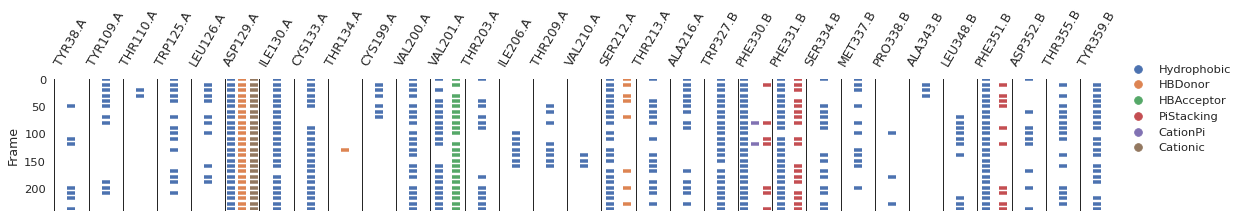

In [17]:
data = pd.melt(df, id_vars=["Frame"], var_name=["residue","interaction"])
data = data[data["value"] != 0]
data.reset_index(inplace=True, drop=True)
# remove residues appearing less than 1% of the time
# t = data.groupby(["residue","interaction"], as_index=False).agg({"value":"count"}).groupby("residue", as_index=False).agg({"value":"max"})
# todrop = t.loc[t["value"] <= 1].residue.tolist()
# data = data[~data["residue"].isin(todrop)]
# print("Removed", ", ".join(todrop), "- Only a single interaction")


# plot
sns.set_theme(font_scale=1.3, style="white", context="paper")
g = sns.catplot(
    data=data, x="interaction", y="Frame", hue="interaction", col="residue",
    hue_order=["Hydrophobic", "HBDonor", "HBAcceptor", "PiStacking", "CationPi", "Cationic"],
    height=2.5, aspect=0.2, jitter=0, sharex=False, marker="_", s=8, linewidth=3.5,
)
g.set_titles("{col_name}")
g.set(xticks=[], ylim=(-.5, data.Frame.max()+1))
g.set_xticklabels([])
g.set_xlabels("")
g.fig.subplots_adjust(wspace=0)
g.add_legend()
g.despine(bottom=True)
for ax in g.axes.flat:
    ax.invert_yaxis()
    ax.set_title(ax.get_title(), pad=15, rotation=60, ha="center", va="baseline")

In [22]:
from rdkit import DataStructs
bvs = fp.to_bitvectors()
tc = DataStructs.BulkTanimotoSimilarity(bvs[0], bvs)
print(tc[1])

0.6


In [20]:
DataStructs.BulkTanimotoSimilarity?

In [63]:
from collections import defaultdict

In [143]:
# prot-prot interactions
fp = plf.Fingerprint(["Hydrophobic", "HBDonor", "HBAcceptor", 'PiStacking', 'Anionic', 'Cationic'])
ifp = []

tm3_mask = (pmol.residues.number >= 119) & (pmol.residues.number <= 152)

for ts in tqdm(u.trajectory[::10]):
    pmol = plf.Molecule.from_mda(prot)
    tm3 = pmol.residues.select(tm3_mask)
    others = pmol.residues.select(~tm3_mask)

    data = defaultdict(int)
    data["Frame"] = ts.frame
    for lresid, lres in tm3.items():
        for presid, pres in others.items():
            bs = fp.bitvector(lres, pres)
            data[presid] |= bs

    ifp.append(data)

df = plf.to_dataframe(ifp, fp)
df

Frame     ALA84.A             LEU87.A     ILE88.A     SER90.A             \
         Hydrophobic HBDonor Hydrophobic Hydrophobic Hydrophobic HBAcceptor   
0      0           0       0           1           1           1          1   
1     10           1       0           1           1           1          1   
2     20           1       1           1           1           1          1   
3     30           0       0           1           1           1          1   
4     40           1       0           1           1           1          1   
5     50           0       0           1           0           1          1   
6     60           0       0           1           0           1          1   
7     70           0       0           1           0           1          1   
8     80           0       0           1           0           1          1   
9     90           1       0           1           1           1          1   
10   100           1       0           1           0           1          1   
11   110           0       0           1           1           1          1   
12   120           0       0           1           1           1          1   
13   130           0       0           1           1           1          1   
14   140           0       0           1           1           1          1   
15   150           0       0           1           1           1          1   
16   160           0       0           1           0           1          1   
17   170           1       0           1           1           1          1   
18   180           0       0           1           1           1          1   
19   190           0       0           1           1           1          1   
20   200           0       0           1           1           1          1   
21   210           0       0           1           1           1          1   
22   220           0       0           1           1           1          1   
23   230           0       0           1           1           1          1   
24   240           0       0           1           1           1          1   

       LEU91.A     THR94.A    ASP95.A  ... THR313.B    LEU316.B    ILE319.B  \
   Hydrophobic Hydrophobic HBAcceptor  ...  HBDonor Hydrophobic Hydrophobic   
0            1           1          0  ...        0           1           1   
1            1           1          0  ...        0           1           1   
2            1           1          0  ...        0           1           0   
3            1           1          0  ...        0           1           1   
4            1           1          0  ...        0           1           1   
5            1           1          0  ...        0           1           1   
6            1           1          0  ...        0           1           1   
7            1           1          0  ...        0           1           0   
8            1           1          0  ...        0           1           1   
9            1           1          0  ...        0           1           1   
10           1           1          0  ...        0           1           1   
11           0           1          0  ...        0           1           1   
12           1           1          0  ...        0           1           1   
13           1           1          0  ...        0           1           1   
14           1           1          0  ...        0           1           0   
15           1           1          0  ...        0           1           1   
16           1           1          1  ...        0           1           1   
17           1           1          0  ...        0           1           1   
18           1           1          0  ...        1           1           1   
19           1           1          0  ...        1           1           1   
20           1           1          0  ...        1           1           1   
21           1           1          0  ...        0 

In [144]:
df.T

0   1   2   3   4   5   6   7   8   9   ...   15   16  \
Frame                  0  10  20  30  40  50  60  70  80  90  ...  150  160   
ALA84.A  Hydrophobic   0   1   1   0   1   0   0   0   0   1  ...    0    0   
         HBDonor       0   0   1   0   0   0   0   0   0   0  ...    0    0   
LEU87.A  Hydrophobic   1   1   1   1   1   1   1   1   1   1  ...    1    1   
ILE88.A  Hydrophobic   1   1   1   1   1   0   0   0   0   1  ...    1    0   
...                   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...   
TRP327.B Hydrophobic   1   1   1   1   1   1   1   0   1   0  ...    1    1   
PHE331.B Hydrophobic   1   1   1   1   1   1   1   1   1   1  ...    0    0   
TYR359.B Hydrophobic   0   1   1   1   1   1   1   1   1   1  ...    1    1   
         HBAcceptor    1   1   1   1   1   1   1   1   1   1  ...    1    1   
TYR369.B Hydrophobic   0   1   0   0   0   0   0   0   0   0  ...    0    0   

                       17   18   19   20   21   22   23   24  
Frame                 170  180  190  200  210  220  230  240  
ALA84.A  Hydrophobic    1    0    0    0    0    0    0    0  
         HBDonor        0    0    0    0    0    0    0    0  
LEU87.A  Hydrophobic    1    1    1    1    1    1    1    1  
ILE88.A  Hydrophobic    1    1    1    1    1    1    1    1  
...                   ...  ...  ...  ...  ...  ...  ...  ...  
TRP327.B Hydrophobic    1    1    1    1    1    1    1    1  
PHE331.B Hydrophobic    1    1    0    1    1    1    1    1  
TYR359.B Hydrophobic    1    1    1    1    1    1    1    1  
         HBAcceptor     1    1    1    1    1    1    1    0  
TYR369.B Hydrophobic    0    0    0    0    0    0    0    0  

[124 rows x 25 columns]

In [145]:
bvs = plf.to_bitvectors(ifp, fp)
for bv in bvs[::10]:
    tc = DataStructs.TanimotoSimilarity(bvs[0], bv)
    print(tc)

1.0
0.6388888888888888
0.6438356164383562


In [ ]:
# For WSL2: portforward requests from localhost:9123 to windows-localhost:9123
# in windows firewall: Add rule to allow connections to port 9123 TCP
# in a powershell with admin rights:
# netsh interface portproxy add v4tov4 listenport=9123 listenaddress=0.0.0.0 connectport=9123 connectaddress=127.0.0.1
# in a wsl2 shell:
# socat -d -d TCP-LISTEN:9123,reuseaddr,fork TCP:$(cat /etc/resolv.conf | tail -n1 | cut -d " " -f 2):9123

In [22]:
colors = {
    "HBAcceptor": "red",
    "FaceToFace": "blue",
    "EdgeToFace": "orange",
}
s = PyMol.MolViewer()
s.DeleteAll()
s.ShowMol(lig_mol[0], name="ligand", showOnly=False, showSticks=True)
s.server.do("color cyan, ligand and elem C")
for res in ifp.keys():
    ids = [t for t in atoms[res] if t[0] is not None][0]
    for a1 in lig_mol[0].GetAtoms():
        if a1.GetUnsignedProp("mapindex") == ids[0]:
            break
    
    for a2 in prot_mol[res].GetAtoms():
        if a2.GetUnsignedProp("mapindex") == ids[1]:
            break
    resname = f"res{str(res)[:-2]}"
    s.ShowMol(prot_mol[res], name=resname, showOnly=False)
    s.server.do(f"color green, {resname} and elem C")
    s.server.do(f"distance lig-{resname}, ligand and id {a1.GetIdx()+1}, {resname} and id {a2.GetIdx()+1}")
    s.server.do(f"hide label, lig-{resname}")
    itype = list(fp.interactions.keys())[np.where(ifp[res] == True)[0][0]]
    color = colors[itype]
    s.server.do(f"color {color}, lig-{resname}")

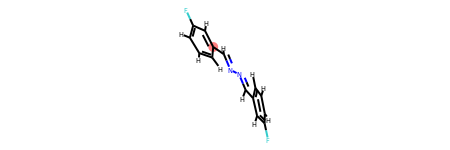

In [74]:
atom_idx = 10
mol = lig_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

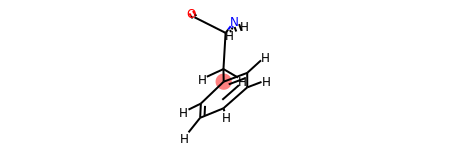

In [75]:
atom_idx = 714
mol = prot_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

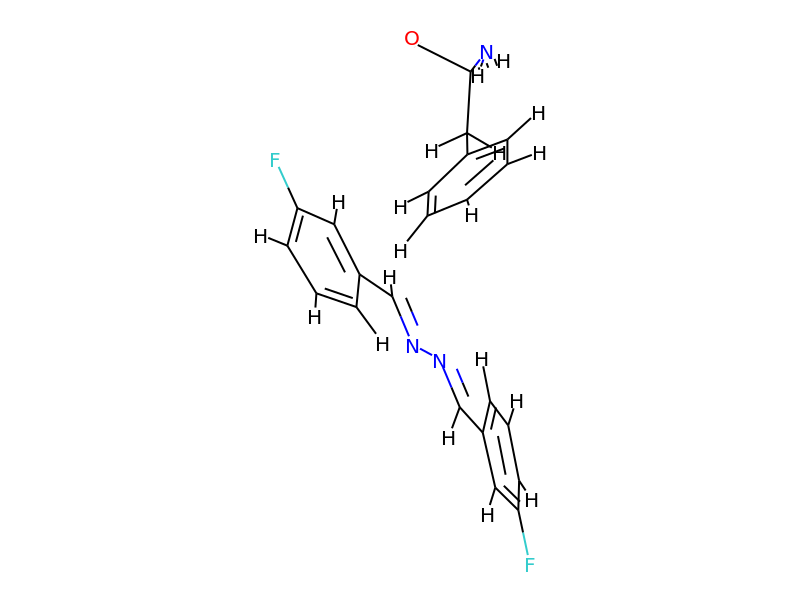

In [76]:
mol = AllChem.CombineMols(prot_mol["PHE222.M"], lig_mol[0])
Draw.MolToImage(mol, size=(800,600))

In [ ]:
# old code

In [11]:
from math import pi
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, FactorRange, HoverTool, Legend, FixedTicker

In [12]:
# interactive plot
output_notebook()

data_bokeh = data.drop(columns="value").copy()
interactions = data_bokeh.interaction.unique()
colors = Category10.get(len(interactions))
residues = data_bokeh.residue.unique()
x_range = [(residue, interaction) for residue in residues for interaction in interactions]

renderers = []
legend_items = []
p = figure(x_range=FactorRange(*x_range), plot_width=900, plot_height=1800)
for i, (interaction, color) in enumerate(zip(interactions, colors)):
    d = data_bokeh.loc[data_bokeh["interaction"]==interaction]
    x = [(r,i) for r in d.residue]
    y = d["Frame"]
    r = p.dash(
        x=x, y=y, color=color,
        line_width=2, size=5, alpha=0.7, hover_alpha=1.0,
    )
    #renderers.append(r)
    legend_items.append((interaction,[r]))

p.add_tools(HoverTool(
    tooltips=[("Frame","@y")], mode='hline',
    #tooltips=None, renderers=renderers, mode='hline'
))
p.y_range.start = -1
p.y_range.end = data_bokeh.Frame.max()+1

p.ygrid.visible = False
p.xgrid.grid_line_alpha = 0.5
p.xgrid.ticker = p.xaxis[0].ticker
p.xaxis.group_label_orientation = pi/2
p.xaxis.major_label_text_color = None

p.add_layout(Legend(items=legend_items, click_policy="hide"), 'right')

show(p)

Loading BokehJS ...